# MNIST numbers classification example with VAE + Classifier

In [1]:
# First install the library

# %pip install rapidae

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))

import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras import utils
from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import evaluate, plot_label_clusters
from rapidae.models.base.default_architectures import Decoder_Conv_MNIST, Encoder_Conv_MNIST
from rapidae.models.vae.vae_model import VAE
from rapidae.pipelines.training import TrainingPipeline

# For reproducibility in Keras 3. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
utils.set_random_seed(1)

### Download and preprocess the dataset

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

Train and test data are normalized.

We also need to convert the labels into one-hot encoding.

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

y_train_orig = copy.copy(y_train)
y_test_orig = copy.copy(y_test)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Obtaint number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-27 13:48:28 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-27 13:48:28 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-27 13:48:28 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-27 13:48:28 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


### Model creation

In this example we are using a variational autoencoder with a classifier attached to its latent space. Weights have been included for the classifier loss as well as for the vae loss in order to increase the classifying capability of the model.

In [6]:
# Model creation
model = VAE(input_dim=(x_train.shape[1], x_train.shape[2]), latent_dim=10, downstream_task='classification',
            encoder=Encoder_Conv_MNIST, decoder=Decoder_Conv_MNIST, layers_conf=[32, 64], n_classes=n_classes,
            weight_vae=0.25, weight_clf=20)

2023-12-27 13:48:28 [INFO]: Classificator available for the latent space of the autoencoder


### Training pipeline

Define the training pipeline. There you can fix some hyperparameters related to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc.
Here you can define callbacks to the model.
Also the pipeline's name can be customized to facilitate the identification of the corresponding folder with the saved models inside output_dir folder.

In [7]:
pipe = TrainingPipeline(name='training_pipeline_mnist_conv_vae',
                        model=model, num_epochs=20, batch_size=128)

trained_model = pipe(x=x_train.astype(float), y=y_train)

2023-12-27 13:48:28 [INFO]: +++ training_pipeline +++
2023-12-27 13:48:28 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-27_13-48-28


Epoch 1/20


/home/lucaspc/aepy-project/rapidae/.venv/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:88: UserWarning: You might experience inconsistencies accross backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(



Epoch 1: loss improved from inf to 13.45728, saving model to ../output_dir/training_pipeline_2023-12-27_13-48-28/model.weights.h5
469/469 - 4s - 9ms/step - clf_loss: 0.5081 - kl_loss: 13.1201 - loss: 13.4573 - reconstruction_loss: 0.0616
Epoch 2/20

Epoch 2: loss improved from 13.45728 to 5.00675, saving model to ../output_dir/training_pipeline_2023-12-27_13-48-28/model.weights.h5
469/469 - 4s - 8ms/step - clf_loss: 0.1283 - kl_loss: 9.7120 - loss: 5.0068 - reconstruction_loss: 0.0503
Epoch 3/20

Epoch 3: loss improved from 5.00675 to 4.11014, saving model to ../output_dir/training_pipeline_2023-12-27_13-48-28/model.weights.h5
469/469 - 4s - 8ms/step - clf_loss: 0.0969 - kl_loss: 8.6404 - loss: 4.1101 - reconstruction_loss: 0.0505
Epoch 4/20

Epoch 4: loss improved from 4.11014 to 3.61509, saving model to ../output_dir/training_pipeline_2023-12-27_13-48-28/model.weights.h5
469/469 - 4s - 8ms/step - clf_loss: 0.0785 - kl_loss: 8.1282 - loss: 3.6151 - reconstruction_loss: 0.0507
Epoch 5

### Evaluation step 


Let's now display the label clusters of the latent space.

(10000, 28, 28, 1)
(10000, 10)


/home/lucaspc/aepy-project/rapidae/.venv/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:88: UserWarning: You might experience inconsistencies accross backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


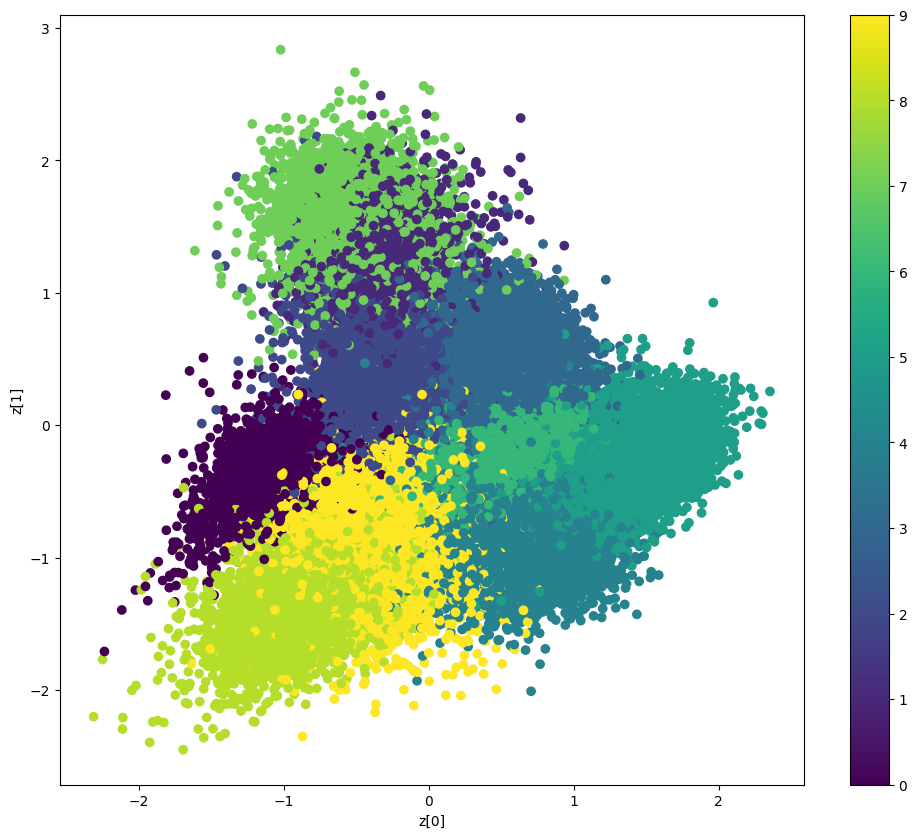

In [13]:
plot_label_clusters(trained_model, x_train, y_train_orig)

Let's now check the classification metrics with the classification_report() function oof Scikit-Learn and using the evaluate function of Rapidae.

In [11]:
from sklearn.metrics import classification_report

# y_train_predict = model.predict(train_data)
y_test_predict = trained_model.predict(x_test)

print(np.argmax(y_test_predict['clf'], axis=1))
print(np.argmax(y_test, axis=1))

target_names = ['number 0', 'number 1', 'number 2', 'number 3',
                'number 4', 'number 5', 'number 6', 'number 7', 'number 8', 'number 9']

# classification_report(y_train, np.argmax(y_train_predict['clf'], axis=1), target_names=target_names)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(
    y_test_predict['clf'], axis=1), target_names=target_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
              precision    recall  f1-score   support

    number 0       0.99      0.98      0.99       980
    number 1       0.99      0.99      0.99      1135
    number 2       0.97      0.99      0.98      1032
    number 3       0.98      0.98      0.98      1010
    number 4       0.97      0.97      0.97       982
    number 5       0.99      0.98      0.98       892
    number 6       0.99      0.99      0.99       958
    number 7       0.97      0.99      0.98      1028
    number 8       0.99      0.97      0.98       974
    number 9       0.97      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [12]:
y_hat = trained_model.predict(x_test)

evaluate(y_true=np.argmax(y_test, axis=1),
         y_hat=np.argmax(y_hat['clf'], axis=1),
         sel_metric=accuracy_score)

 54/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/home/lucaspc/aepy-project/rapidae/.venv/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:88: UserWarning: You might experience inconsistencies accross backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
test set results: [
	 accuracy_score: 0.9808 
]


0.9808